# 1.0 Introduction






 we use Twitter data to create and explore directed networks of social interactions. For this lesson, we'll be using a developer workflow where we assume you have access to an app's API key and secret (see the slides).


Contents:

1. Introduction
2. Authenticating with Twitter's API
2. Twitter API basics
3. Using Twitter's search API to get tweets of interest
4. Creating social network graphs
5. Twitter retweet network
6. Twitter mention network

***Copyright:*** *Parts of the contents of this Colab Notebook, unless otherwise indicated, are Copyright 2020 Filippo Menczer, Santo Fortunato and Clayton A. Davis, [A First Course in Network Science](https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience). All rights reserved.* 

***References***: getting started with the Twitter API v2 for academic research [here](https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research). 


# 2.0 Authenticating with Twitter's API



Twitter uses OAuth in order to allow third-party apps to access data on your behalf without requiring your Twitter login credentials -- note that none of the code in this notebook asks for your Twitter screen name or password.

The OAuth "dance" can be intimidating when you first use it, but it provides a far more secure way for software to make requests on your behalf than providing your username and password.

We'll make use of the
[Twython](https://twython.readthedocs.io/en/latest/usage/starting_out.html#authentication)
package to help us with authentication and querying Twitter's APIs.

In [ ]:
!pip install Twython wordcloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
from twython import Twython, TwythonError
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline


## 2.1 Enter app info and get auth URL



In order to authenticate with Twitter, we'll provide the app details and  ask for a one-time authorization URL to authenticate your user with this app.

Copy and paste the API key and secret from your Twitter app into a file named <font color="red">keys.txt</font>. The first line is the API_KEY and the second line of the file is API_SECRET_KEY. For example, a template for the <font color="red">keys.txt</font>: 

```python
df6cf09894907b92f3ea749ef
d19c40cbb184f72055c806f107b5158d023a43eb7d8921a0d0
```

In [ ]:
# open the keys file
my_file = open("keys.txt", "r")

# read the raw data
content = my_file.read()

# split all lines by  newline character
API_KEY, API_SECRET_KEY = content.split("\n")

# close the file
my_file.close()

Executing the cell should then print out a clickable URL. This link is unique and will work **exactly** once. <font color="red"> Visit this URL, log into Twitter, and then copy the verifier pin that is given to you so as to paste it in the next step</font>.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY)

authentication_tokens = twitter.get_authentication_tokens()
print(authentication_tokens['auth_url'])

https://api.twitter.com/oauth/authenticate?oauth_token=YppAsgAAAAABZBbPAAABfvWq3X4


## 2.2 Authorize app using verifier PIN



That verifier PIN goes into the next cell. This will be different every time you run these steps. The `authentication_tokens` include temporary tokens that go with this verifier PIN; by submitting these together, we show Twitter that we are who we say we are.

In [ ]:
# Replace the verifier with the pin number obtained with your web browser in the previous step
VERIFIER = ' '

twitter = Twython(API_KEY, API_SECRET_KEY,
                  authentication_tokens['oauth_token'],
                  authentication_tokens['oauth_token_secret'])

authorized_tokens = twitter.get_authorized_tokens(VERIFIER)


## 2.3 Use authorized tokens



Now we have a permanent token pair that we can use to make authenticated calls to the Twitter API. We'll create a new Twython object using these authenticated keys and verify the credentials of the logged-in user.

In [ ]:
twitter = Twython(API_KEY, API_SECRET_KEY,
                  authorized_tokens['oauth_token'],
                  authorized_tokens['oauth_token_secret'])

twitter.verify_credentials()

If the previous cell ran without error and printed out a dict corresponding to a
[Twitter User](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object),
then you're good. The authorized token pair is like a username/password and should be protected as such.



# 3.0 Searching and build graph



In this lesson, we'll be dealing with two different types of data, Users and Tweets.



In [ ]:
for word in list_descriptions:
  if 'https' in word:
    list_descriptions.remove(word)

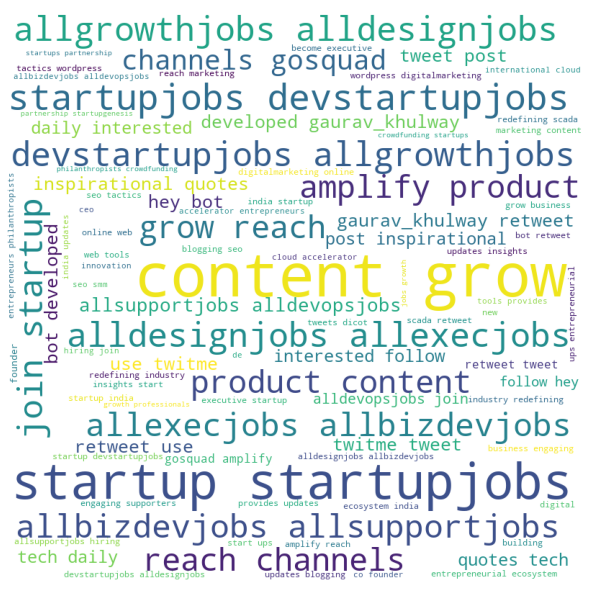

In [ ]:
words_to_remove = ['https', 'startup']


comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in list_descriptions:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('imgs/word_cloud.png', transparent=True,dpi=300,bbox_inches="tight")
plt.show()

### 3.1.1 Playing with followeres with Twython

It doesn’t need to be said that **Followers** are, and should be, the driving force behind your social success on Twitter. You need to make your **Followers** feel special for Following you. And you need to get as much information about them as possible, so you can analyse your follower demographics for further analysis and targeting. So you can find out exactly how you can make them feel even more special! And feel that following you is worthwhile….

But before you can do any of that, <font color="red"> you first need to get some idea of who your followers are</font>. So let’s start on the basics!

- GET followers/list [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/accounts-and-users/follow-search-get-users/api-reference/get-followers-list).

In [ ]:
# there are some rate limitations in order to use the Twitter API
# you can see the current limits calling get_applicaiton_rate_limit_status()
twitter.get_application_rate_limit_status()['resources']

In [ ]:
# current limits to followers/list endpoint
twitter.get_application_rate_limit_status()['resources']['followers']

In [ ]:
# During the writing of this notebook UFRN twitter user has
# 15507 followers. So, at maximum is possible to retrieve 200 x 15 followers in just a call.
# Thus, considering only 15 calls are allowed during a window of 15 min
# it will be necessary at least 6 calls to collect all UFRN followers
# 6 calls x 15min = 90min!!!!
15507/(200 * 15)

## 3.2 Tweet Objects



The second type of data of which we will make use is the
[Tweet Object](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object).
A user object actually contains the user's most recent tweet:

In [ ]:
# fetch data from UFRN's user
user = twitter.show_user(screen_name='ufrnbr')

In [ ]:
most_recent_tweet = user['status']
most_recent_tweet

Tweet objects contain several interesting data and metadata, but the most basic are the `'text'` and `'entities'`. The `'text'` is what you expect it to be: the text of the tweet:

In [ ]:
most_recent_tweet['text']

The `'entities'` field contains several tokens of interest already extracted from the tweet such as hashtags, URLs, images, and mentions of other users:

In [ ]:
most_recent_tweet['entities']

In particular, we'll make use of the `'user_mentions'` later:

In [ ]:
most_recent_tweet['entities']['user_mentions']

# 4.0 Using Twitter's search API to get tweets of interest



Twitter's
[Search API](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html)
allows you to fetch recent tweets according to a query of keywords, URLs, hashtags, user mentions, etc.



## 4.1 Get tweets matching a hashtag

We'll make use of the ability to search by hashtags:

In [ ]:
search_response = twitter.search(q='startup', count=100 , lang='pt')

In [ ]:
search_response

2

In [ ]:
# current limits to followers/list endpoint
twitter.get_application_rate_limit_status()['resources']["search"]

{'/search/tweets': {'limit': 180, 'remaining': 176, 'reset': 1644715181}}

While the search API response is a dictionary, the `'statuses'` field contains the list of
[Tweet Objects](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)
we're after.

In [ ]:
search_tweets = search_response['statuses']
tweet = search_tweets[1]
tweet

Note that each tweet obtained from this API contains a `'user'` field -- this is a User Object for the user who created the tweet.

In [ ]:
tweet['user']

## 4.2 Using a cursor to get more than 100 tweets from a search

We can only fetch up to 100 tweets at a time from a single search API call:

In [ ]:
search_response['statuses'][1]['user']

In [ ]:
len(search_response['statuses'])

100

In [ ]:
search_response[0]

In [ ]:
hashtags = [re.findall('#\w+', i) for i in x]

In [ ]:
len(search_tweets)

3000

In [ ]:
import itertools

#search_response = twitter.search(q='#startup', count=100 )

NUM_TWEETS_TO_FETCH = 7000

cursor = twitter.cursor(twitter.search, q='#startup', count=100,result_type='mixed')

search_tweets = list(itertools.islice(cursor, NUM_TWEETS_TO_FETCH))
len(search_tweets)

7000

In [ ]:
MINIMUN_FOLLOW_COUNT = 500

list_descriptions = []
list_hastags = []
i = 0
for tweet in search_tweets:
  i+=1
  #hashtags = [tweet_['text'].lower() for tweet_ in tweet['entities']['hashtags']]
  
  hashtags = re.findall(r'[#@][^\s#@]+', tweet['user']['description'])
  if len(hashtags)>0 and (tweet['user']['followers_count'] >= MINIMUN_FOLLOW_COUNT):
    list_descriptions.extend(tweet['user']['description'].split(" "))
    list_hastags.append(hashtags)
print(i)
list_hastags

In [ ]:
list_descriptions

In [ ]:
tweets_df

In [ ]:
import itertools

tweets_df = pd.DataFrame({'hashtags':list_hastags})

col1 = []
col2 = []
for index, row in tweets_df.iterrows():
    hashtags=row['hashtags']
    hashtags_len = len(hashtags)
    for n in list(itertools.combinations(hashtags, 2)):
        col1.append(n[0])
        col2.append(n[1])

df = pd.DataFrame(list(zip(col1, col2)),columns=['source','target'])


In [ ]:
df.describe()

,source,target
count,22145,22145
unique,1403,1426
top,#OnlineBusiness,#SmallBusiness
freq,1821,1650


In [ ]:
adj_list_df = pd.DataFrame({'count' : df.groupby(['source', 'target']).size()}).reset_index()
adj_list_df.source.value_counts()[]

#AI                60
#startup           46
#startups          45
#Innovation        41
#Startup           36
                   ..
@CervantesyCia.     1
#Emprendedores      1
@CapitoleAngels     1
#BI                 1
@zuena_ng           1
Name: source, Length: 1403, dtype: int64

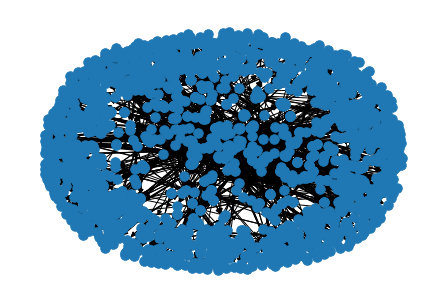

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


g = nx.from_pandas_edgelist(adj_list_df, source='source', target='target', edge_attr='count', create_using=nx.DiGraph())

pos = nx.spring_layout(g,seed=42)
nx.draw(g, pos,node_size=90)
labels = nx.get_edge_attributes(g, 'count')
#nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
plt.show()

In [ ]:
for status in search_response['statuses']:
  print(status['text'])

In [ ]:
list_languages = []
for tweet in search_tweets:
  lang = tweet['metadata'].get('iso_language_code')
  if lang and lang != 'en':
    list_languages.append(lang)

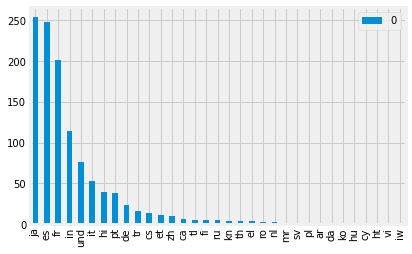

In [ ]:
from collections import Counter
import pandas

count = Counter(list_languages)
df = pandas.DataFrame.from_dict(count, orient='index')
df = df.sort_values(by=[df.columns[0]], ascending=False)
df.plot(kind='bar')

In [ ]:
search_tweets[0]

Let's usea workaround to fetch more than 100 resuts with hashtag #startup

In [ ]:
search_response

In [ ]:
df.head()

,source,target
0,@UrstrulyMahesh,@ImVkohli
1,@UrstrulyMahesh,@RishabhPant17
2,@ImVkohli,@RishabhPant17


In [ ]:
df.shape

In [ ]:
search_response[5]

In [ ]:
search_response = search_tweets

Note the following:
* The cursor object is a
[generator](https://docs.python.org/3/tutorial/classes.html#generators),
a type of iterator that "lazily" generates items. We use Python's `itertools.islice` in order to get up to a set number of items from this generator. The second argument passed to `islice` is the max number of tweets we want to fetch from the user.
* Even though we want to get more than 100 tweets here, we provide the `count=100` argument. This tells the cursor to fetch the maximum number of tweets with each API call.
* As documented in [Twitter's Search API documentation](https://developer.twitter.com/en/docs/tweets/search/api-reference/get-search-tweets.html), specifying `result_type='mixed'` provides a mix of recent and popular tweets matching the query. If one desires a more "random" sample, you can specify `result_type='recent'`, but Twitter may provide fewer tweets than desired.

## 4.3 API method rate limits

Each API method has a *rate limit* imposed by Twitter, a limit on the number of function calls per 15-minute window. We can check on the rate limit status for this endpoint:

In [ ]:
twitter.get_application_rate_limit_status()['resources']['search']

{'/search/tweets': {'limit': 180, 'remaining': 119, 'reset': 1644722645}}

These limits apply to the number of API *calls*, as opposed to the number of *items* fetched. This is why, when creating a cursor, we specify `count=` to fetch the maximum number of items per API call.

In [ ]:
max(D.nodes, key=D.out_degree)

In [ ]:
from operator import itemgetter

sorted(g.out_degree(), key=itemgetter(1), reverse=True)[:10]

[('#AI', 60),
 ('#startup', 46),
 ('#startups', 45),
 ('#Innovation', 41),
 ('#IoT', 36),
 ('#Startup', 36),
 ('#Fintech', 36),
 ('#tech', 34),
 ('#innovation', 29),
 ('#BigData', 27)]

### 6.4.3 Connectivity



We can ask if the there are small clusters

In [ ]:
nx.is_weakly_connected(g)

In [ ]:
nx.number_weakly_connected_components(g)

312

# 7.0 Twitter mention network



Another Twitter interaction between users occurs when one user mentions another in a tweet by their @screen_name. As an example, consider the following hypothetical tweet from @osome_iu:

> Check out the new research from @IUSICE and @USC_ISI https://...

From this tweet we would create two edges:

    ('osome_iu', 'IUSICE')
    ('osome_iu', 'USC_ISI')

It's up to us which direction we draw these edges, but we should be consistent. In this example, we will draw edges in the direction of attention flow: @osome_iu is giving attention to @IUSICE and @USC_ISI.


### 7.3.4 Drawing



We can try to draw this graph with the nodes sized by their in-strength:

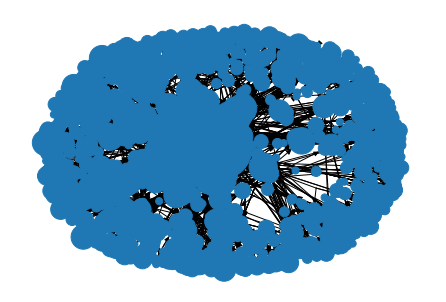

In [ ]:
node_sizes = [g.in_degree(n, weight='weight') * 50 for n in g.nodes]

%matplotlib inline
nx.draw(g, node_size=node_sizes)

Note that in this simplistic drawing, nodes with zero in-strength are not drawn on the diagram because their size is 0. This suits us fine; only the users who have been mentioned are drawn here.

In [ ]:
nx.write_graphml(g, "startup_users_descriptions.graphml")


In [ ]:
g = nx.read_graphml("startup_users_descriptions.graphml")
%matplotlib inline


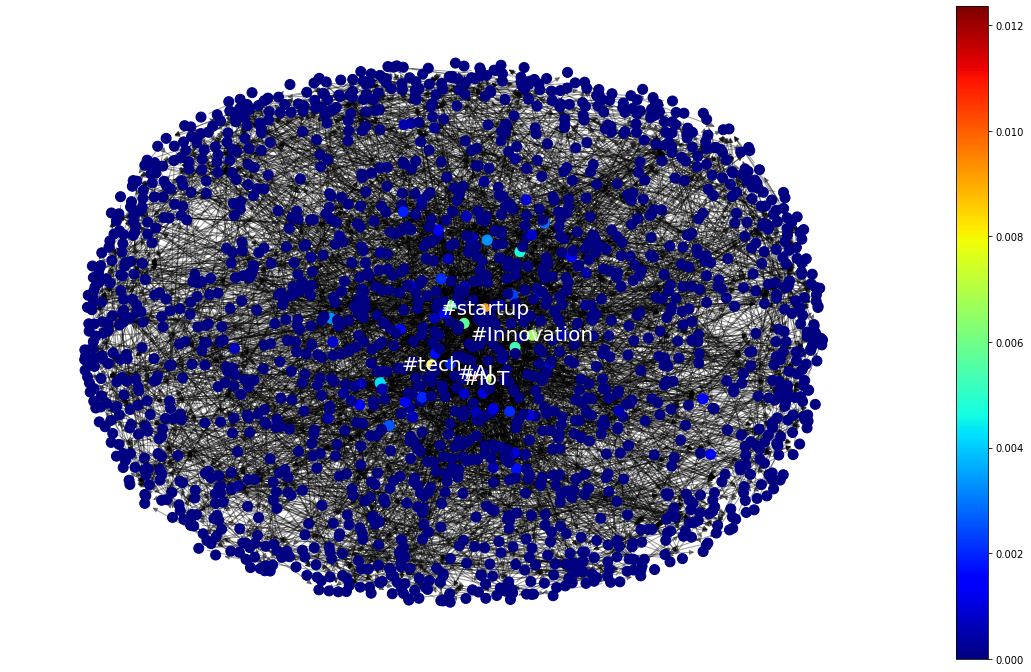

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(20,12))

# layout position
pos = nx.spring_layout(g,seed=42,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(g)).values())

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet,
                 ax=ax,node_size=100)

# draw labels
nx.draw_networkx_labels(g, pos=pos, labels=labels,
                      font_color='white', ax=ax,font_size=20)


plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/betweenness_centrality_w_labels.png', transparent=False,dpi=600)
plt.show()

In [ ]:
labels = {}    
for node in G.nodes():
    if node in hubs:
        #set the node name as the key and the label as its value 
        labels[node] = node

In [ ]:
dict_colors = dict(nx.betweenness_centrality(g))

In [ ]:
[(labels[label]) for label in labels.keys() if label == labels[label]]

['#IoT', '#AI', '#tech', '#Innovation', '#startup']

In [ ]:


labels = {}    
for node in g.nodes():
        #set the node name as the key and the label as its value 
        labels[node] = node if dict_colors[node] in sorted(color)[-5:] else ""

In [ ]:
sorted(color)[-3:]

[0.008310215285085586, 0.009219602288315979, 0.012355764079704113]

## EIGV CENTRALITY


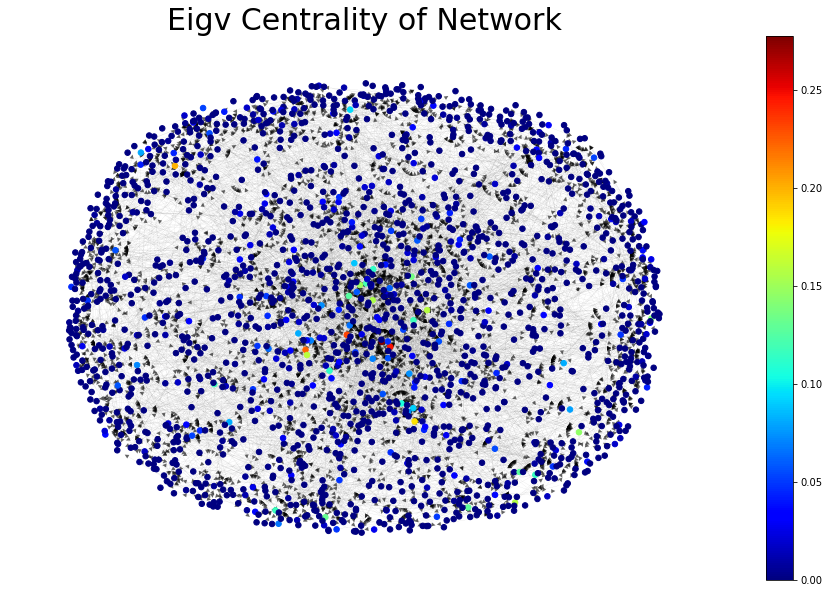

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(16,10))

#layout position
pos = nx.spring_layout(g,seed=42,k=0.3)

# draw edges
color_eigv = list(dict(nx.eigenvector_centrality(g)).values())

nx.draw_networkx_edges(g,
                       pos=pos,
                       width=0.05,
                       alpha=0.6, 
                       ax=ax)
# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color=color_eigv,
                 cmap=plt.cm.jet,
                 ax=ax,
                 node_size=30)

# draw labels
#nx.draw_networkx_labels(g, pos=pos,
#                        font_color='white', ax=ax)

plt.title("Eigv Centrality of Network", fontsize = 30)
plt.axis("off")
plt.colorbar(nodes)
plt.savefig('imgs/eigenvector_centrality.jpg',dpi=300)

In [ ]:
import seaborn as sns

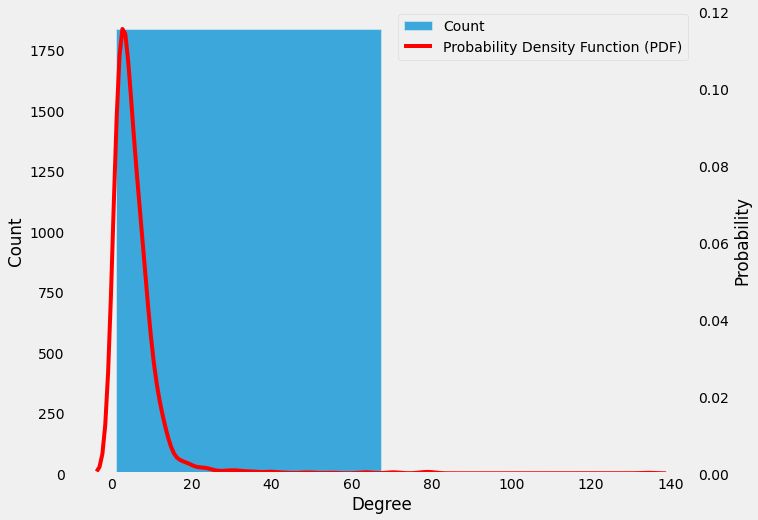

In [ ]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)  

plt.style.use("fivethirtyeight")
#plt.style.use("default")


fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=2,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('imgs/probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()


# fig, ax = plt.subplots(1,1,figsize=(10,8))

# sns.histplot(degree_sequence,bins=3,label="Count",ax=ax)
# ax2 = ax.twinx()
# sns.kdeplot(degree_sequence,color='r',label="Cumulative Density Function (CDF)",ax=ax2,cumulative=True)

# # ask matplotlib for the plotted objects and their labels
# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2, loc=0)

# ax.grid(False)
# ax2.grid(False)
# ax.set_xlabel("Degree")
# ax2.set_ylabel("Probability")

# plt.savefig('imgs/cumulative_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
# plt.show()